In [8]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 


In [11]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text   # for loading the BERT models

## Import the dataset

In [12]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [13]:
747/4825

0.15481865284974095

**Only 15% are spam mail This indicate class imbalance**

In [14]:
required_sample = df[df['Category']=='spam'].shape[0]

In [15]:
df[df['Category'] =='ham']=df[df['Category'] =='ham'].sample(required_sample)

In [16]:
df.shape

(5572, 2)

In [17]:
df['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [18]:
df.isnull().sum()

Category    4078
Message     4078
dtype: int64

In [19]:
df.dropna(axis=0,inplace= True)

In [20]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [22]:
df['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [21]:
df['Category']

0        ham
2       spam
5       spam
8       spam
9       spam
        ... 
5550     ham
5565     ham
5566    spam
5567    spam
5568     ham
Name: Category, Length: 1494, dtype: object

In [23]:
df['spam'] = df['Category'].apply(lambda x: 0 if x=='ham' else 1)

In [24]:
df

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
...,...,...,...
5550,ham,"Cool, what time you think you can get here?",0
5565,ham,Huh y lei...,0
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1
5567,spam,This is the 2nd time we have tried 2 contact u...,1


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'],stratify= df['spam'])

In [39]:
X_train.head()

1205    WIN a year supply of CDs 4 a store of ur choic...
1578    Remember all those whom i hurt during days of ...
3695    Ok im not sure what time i finish tomorrow but...
4948    Great News! Call FREEFONE 08006344447 to claim...
1168              Lol now I'm after that hot air balloon!
Name: Message, dtype: object

In [26]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


## BERT Model

**For this we are using Function model**

In [27]:
# Bert layer
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

# Neural network layer
l1 = tf.keras.layers.Dropout(0.1, name= 'dropout')(output['pooled_output'])
l2 = tf.keras.layers.Dense(1, activation='sigmoid',name= 'output')(l1)

# Use input and output to contruct a final model
model = tf.keras.Model(inputs=[text_input],outputs=[l2])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [51]:
len(X_train)

1120

In [29]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = METRICS)

In [30]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 35s 641ms/step - loss: 0.6796 - accuracy: 0.5946 - precision: 0.5904 - recall: 0.6179
Epoch 2/10
35/35 [==============================] - 23s 647ms/step - loss: 0.5344 - accuracy: 0.8089 - precision: 0.8112 - recall: 0.8054
Epoch 3/10
35/35 [==============================] - 23s 651ms/step - loss: 0.4471 - accuracy: 0.8696 - precision: 0.8696 - recall: 0.8696
Epoch 4/10
35/35 [==============================] - 23s 651ms/step - loss: 0.4003 - accuracy: 0.8768 - precision: 0.8728 - recall: 0.8821
Epoch 5/10
35/35 [==============================] - 23s 651ms/step - loss: 0.3666 - accuracy: 0.8848 - precision: 0.8709 - recall: 0.9036
Epoch 6/10
35/35 [==============================] - 23s 651ms/step - loss: 0.3391 - accuracy: 0.8973 - precision: 0.8938 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 23s 651ms/step - loss: 0.3169 - accuracy: 0.8991 - precision: 0.8901 - recall: 0.9107
Epoch 8/10
35/35 [================

## Model Evaluation

In [31]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 12s 728ms/step - loss: 0.2588 - accuracy: 0.9278 - precision: 0.9301 - recall: 0.9251


[0.25880342721939087,
 0.9278075098991394,
 0.9301075339317322,
 0.9251337051391602]

In [32]:
y_predicted = model.predict(X_test)
y_predicted

array([[0.22311409],
       [0.8335916 ],
       [0.07953587],
       [0.01543867],
       [0.61312747],
       [0.8494355 ],
       [0.04547692],
       [0.13222286],
       [0.3825523 ],
       [0.53974605],
       [0.1893307 ],
       [0.18295524],
       [0.8880081 ],
       [0.04944472],
       [0.9068391 ],
       [0.27388176],
       [0.0266439 ],
       [0.92005897],
       [0.1602833 ],
       [0.88634646],
       [0.76066387],
       [0.13239653],
       [0.28572682],
       [0.8932794 ],
       [0.67154676],
       [0.01406435],
       [0.7129655 ],
       [0.01553317],
       [0.1187643 ],
       [0.06181314],
       [0.06774238],
       [0.76712334],
       [0.07258305],
       [0.09980192],
       [0.954451  ],
       [0.3179685 ],
       [0.8882113 ],
       [0.04759173],
       [0.1575279 ],
       [0.86914223],
       [0.8832951 ],
       [0.11377354],
       [0.88118047],
       [0.6906939 ],
       [0.09334791],
       [0.7209426 ],
       [0.66440177],
       [0.052

In [33]:
y_predicted = y_predicted.flatten()

In [35]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 


array([[174,  13],
       [ 14, 173]])

Text(33.0, 0.5, 'Truth')

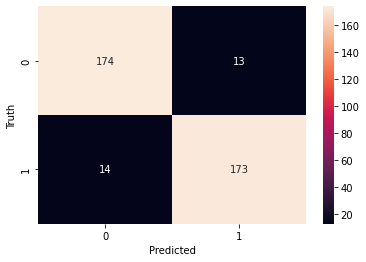

In [37]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       187
           1       0.93      0.93      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



## Inference

In [34]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.67986864],
       [0.78059757],
       [0.6914947 ],
       [0.15506883],
       [0.09836391]], dtype=float32)

## Save the model

In [39]:
model.save("Spam_ham_detector_model.h5")